In [2]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
import time
import datetime as dt

For a brief contextualization, a cohort is a group of individuals sharing a common characteristic, allowing us to observe and compare their behavior over time with other cohorts.

### Types of Cohorts:
- **Time Cohorts**: These consist of customers who began using a product or service within a specific time frame, such as monthly or quarterly. Analyzing these cohorts reveals how customer behavior varies based on when they first engaged with the company’s offerings.
- **Behavior Cohorts**: These group customers by the type of product or service they initially purchased. Different cohorts might have distinct needs based on the product tier they chose, offering insights into tailoring services or products for specific segments.
- **Size Cohorts**: These categorize customers by their spending size over a period or by the product type that represented the majority of their expenditure. This helps identify patterns based on customer size and preferences.

For the cohort analysis, I'll create a few key labels as these targets are essential for measuring cohort characteristics, such as acquisition date and metrics like user retention:
- **Invoice Period**: A string representation of the year and month of a single transaction.
- **Cohort Group**: A string representation of the year and month of a customer’s first purchase, applied consistently across all their invoices.
- **Cohort Period/Index**: An integer representing a customer’s stage in their “lifetime,” showing the number of months since their first purchase.

Given that my data focuses on single products rather than complex services, I'll conduct a Time Cohort analysis, specifically targeting monthly cohorts.

Import the cleaned data from previous analysis for the cohort:

In [10]:
cohort = pd.read_csv('data_cleaned.csv')

cohort

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Total_cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,2010,12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,2010,12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,2010,12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,2010,12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,2010,12,20.34
...,...,...,...,...,...,...,...,...,...,...,...
392727,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France,2011,12,10.20
392728,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France,2011,12,12.60
392729,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France,2011,12,16.60
392730,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France,2011,12,16.60


### Monthly acquisition cohort
Based on the month each customer has made their first transaction, I will now create monthly cohorts.

In [24]:
### Cohort Month ####

#change InvoiceDate to date time format 
cohort['InvoiceDate'] = pd.to_datetime(cohort['InvoiceDate'])

#function that extracts the year and month from datetime object, setting the day to the first of the month
def get_month(x):
    return dt.datetime(x.year, x.month, 1)  

cohort['InvoiceMonth'] = cohort['InvoiceDate'].apply(get_month)

#group by CustomerID and select the InvoiceMonth value
grouping = cohort.groupby('CustomerID')['InvoiceMonth']

#Assign a minimum InvoiceMonth value to the dataset
cohort['CohortMonth'] = grouping.transform('min')

### Calculate Time Offset in Months  
To analyze each cohort consistently, one needs to calculate the time offset for each transaction. This calculation allows for the reporting of metrics in a comparable manner across different cohorts. 

First, one must create variables that capture the integer values for the year and month of both the Invoice Date and the Cohort Date using the `get_date_int()` function.

In [34]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [36]:
invoice_year, invoice_month = get_date_int(cohort,'InvoiceMonth')

cohort_year, cohort_month = get_date_int(cohort,'CohortMonth')

In [38]:
### Cohort Index ###

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

#Cohort index definition using difference i years and months
cohort['CohortIndex'] = years_diff * 12 + months_diff + 1 

### Cohort Exploratory Analysis

A first attempt to cohort analysis grouping by the targets and using `pd.pivot_table()` to transform the grouped data into a format commonly recognized as a cohort table. This process allows for a comprehensive view of the cohort's performance over time.

In [43]:
cohort_data = cohort.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()

#Take the cohort_data and plumb it into a Pivot Table. 
cohort_count = cohort_data.pivot_table(index = 'CohortMonth',
                                       columns = 'CohortIndex',
                                       values = 'CustomerID')
cohort_count

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.00,324.00,286.00,340.00,321.00,352.00,321.00,309.00,313.00,350.00,331.00,445.00,235.00
2011-01-01,417.00,92.00,111.00,96.00,134.00,120.00,103.00,101.00,125.00,136.00,152.00,49.00,NaN
2011-02-01,380.00,71.00,71.00,108.00,103.00,94.00,96.00,106.00,94.00,116.00,26.00,NaN,NaN
2011-03-01,452.00,68.00,114.00,90.00,101.00,76.00,121.00,104.00,126.00,39.00,NaN,NaN,NaN
2011-04-01,300.00,64.00,61.00,63.00,59.00,68.00,65.00,78.00,22.00,NaN,NaN,NaN,NaN
2011-05-01,284.00,54.00,49.00,49.00,59.00,66.00,75.00,27.00,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.00,42.00,38.00,64.00,56.00,81.00,23.00,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.00,34.00,39.00,42.00,51.00,21.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.00,35.00,42.00,41.00,21.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The cohort_count pivot table provides a clear view of how many unique customers remain in each cohort over time. But for understanding customer retention it's necessary to calculate retention rates.

### Calculate retention rate
Customer retention is a very useful metric to understand how many of all the customers are still active (percentage of active customers compared to the total number of customers).

In [49]:
cohort_sizes = cohort_count.iloc[:,0]

#Divide the cohort count by cohort sizes along the rows to get retention
retention = cohort_count.divide(cohort_sizes, axis=0)*100

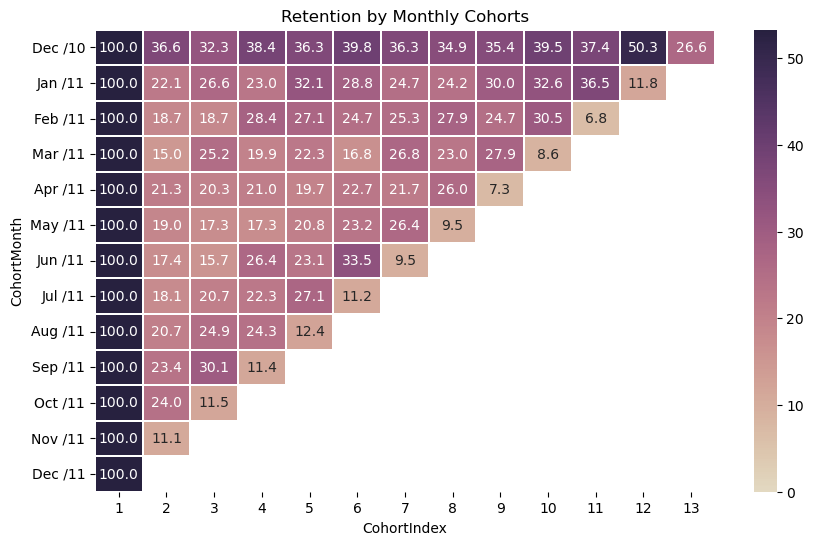

In [65]:
month_list = ["Dec /10", "Jan /11", "Feb /11", "Mar /11", "Apr /11",\
              "May /11", "Jun /11", "Jul /11", "Aug /11", "Sep /11", \
              "Oct /11", "Nov /11", "Dec /11"]

plt.figure(figsize=(10,6))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(data=retention,
            annot = True,
            cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),
            vmin = 0.0,
            vmax = list(retention.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)

plt.show()

### Average Quantity Sold



In [68]:
cohort_data2 = cohort.groupby(['CohortMonth', 'CohortIndex'])['Quantity'].mean().reset_index()
average_quantity  = cohort_data2.pivot(index = 'CohortMonth',
                                            columns = 'CohortIndex',
                                       values = 'Quantity').round(1)

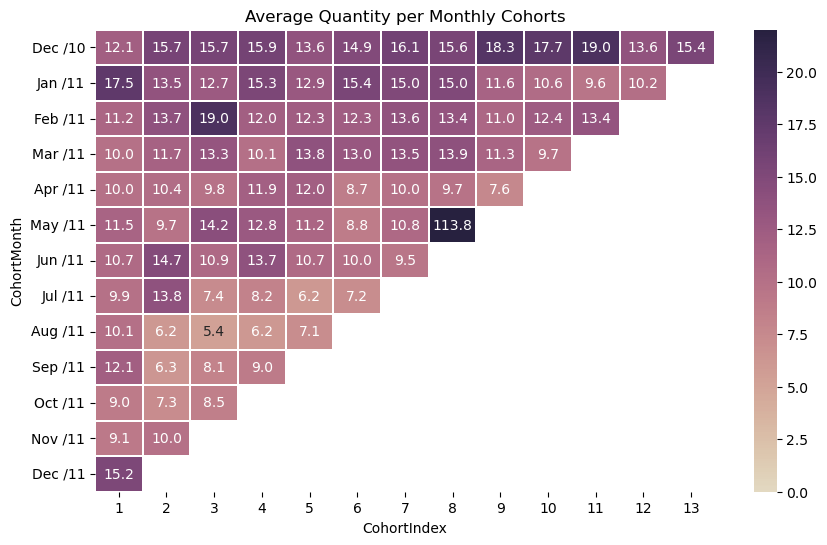

In [70]:
plt.figure(figsize=(10,6))
plt.title('Average Quantity per Monthly Cohorts')
sns.heatmap(data=average_quantity,
            annot = True,
            cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),
            vmin = 0.0,
            vmax = list(average_quantity.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)

plt.show()

### Average price per cohort
It is useful to analyze the price metric and if there are any differences in shopping patterns across time and across cohorts.

In [80]:
cohort_data3 = cohort.groupby(['CohortMonth', 'CohortIndex'])['UnitPrice'].mean().reset_index()
average_price  = cohort_data3.pivot(index = 'CohortMonth',
                                           columns = 'CohortIndex',
                                      values = 'UnitPrice').round(1)
average_price.index = average_price.index.date

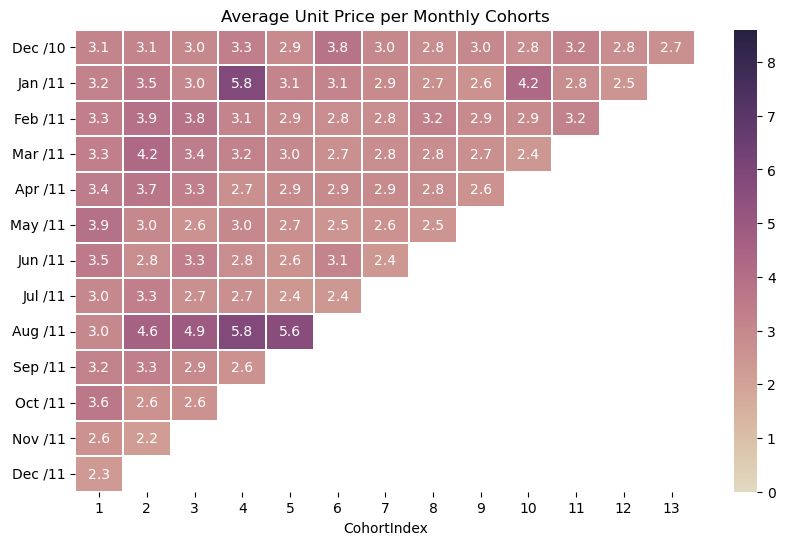

In [82]:
plt.figure(figsize=(10,6))
plt.title('Average Unit Price per Monthly Cohorts')
sns.heatmap(data=average_price,
            annot = True,
            cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),
            vmin = 0.0,
            vmax = list(average_price.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)

plt.show()

### Average Total Sales per Cohort

In [86]:
cohort_data4 = cohort.groupby(['CohortMonth', 'CohortIndex'])['Total_cost'].mean().reset_index()
average_sales  = cohort_data4.pivot(index = 'CohortMonth',
                                    columns = 'CohortIndex',
                                    values = 'Total_cost').round(1)

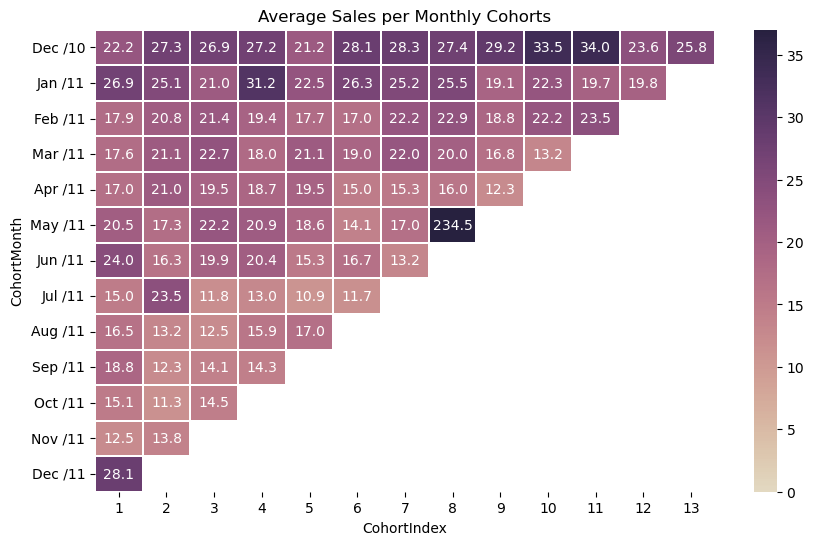

In [88]:
plt.figure(figsize=(10,6))
plt.title('Average Sales per Monthly Cohorts')
sns.heatmap(data=average_sales,
            annot = True,
            cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),
            vmin = 0.0,
            vmax = list(average_sales.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)

plt.show()

### Insights:

* The high average quantity and average sales figures suggest that customers in the May /11 cohort purchased more items and spent more overall on December (Cohort Index 8). This could indicate a strong buying trend or a promotional event that encouraged larger purchases.

* Despite the increase in quantity and sales, the unit price remaining consistent implies that the higher sales and quantities are not due to changes in the price per item. The consistency in unit price suggests that the observed increase in sales is driven by higher purchase volumes rather than price adjustments.

* The diagonal pattern of low retention rates in the last cohort index for all the cohort groups initially suggest a decrease in customer engagement, where customers may become less interested or perceive less value in the product or service. However, given the drastic drop from January to February, followed by a rise toward December, this pattern likely correlates with seasonal factors, such as the impact of Christmas sales and other seasonal variations. This suggests that the observed changes in retention rates may be influenced by monthly trends and holiday-related shopping behavior rather than a straightforward decline in customer engagement. 

* The last one is further supported by the consistent average sales, quantity, and retention observed in December, indicating that seasonal trends and holiday shopping behavior significantly influence these metrics rather than a straightforward decline in customer engagement.

* Despite observing low retention rates in the final cohort index across all groups, there is a noticeable consistency throughout the cohort groups. This uniformity makes it challenging to point out a specific critical period for customer retention after the first purchase. The data suggests that while there is a decline in retention towards the end of each cohort’s timeline, this trend does not clearly establish a critical retention period universally applicable across different cohorts.